In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint,LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df='C:/Users/PC/Documents/Data+Science+for+Business+Package/DataScienceforBusinessPackage/4. Operations Department/Dataset'
os.listdir(df)

['0', '1', '2', '3']

In [3]:
image_generator= ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [4]:
train_generator= image_generator.flow_from_directory(batch_size=40, directory=df, shuffle= True,target_size=(256,256), class_mode='categorical',
                                                    subset='training')

Found 428 images belonging to 4 classes.


In [5]:
train_generator= image_generator.flow_from_directory(batch_size=40, directory=df, shuffle= True,target_size=(256,256), class_mode='categorical',
                                                    subset='validation')

Found 104 images belonging to 4 classes.


In [6]:
train_images, train_labels= next(train_generator)

In [7]:
train_images.shape

(40, 256, 256, 3)

In [8]:
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]],

In [9]:
label_names={0:'COVID-19',1:'Normal',2:'Pneumonia Virica',3:'Pneumonia Bacteriana'}

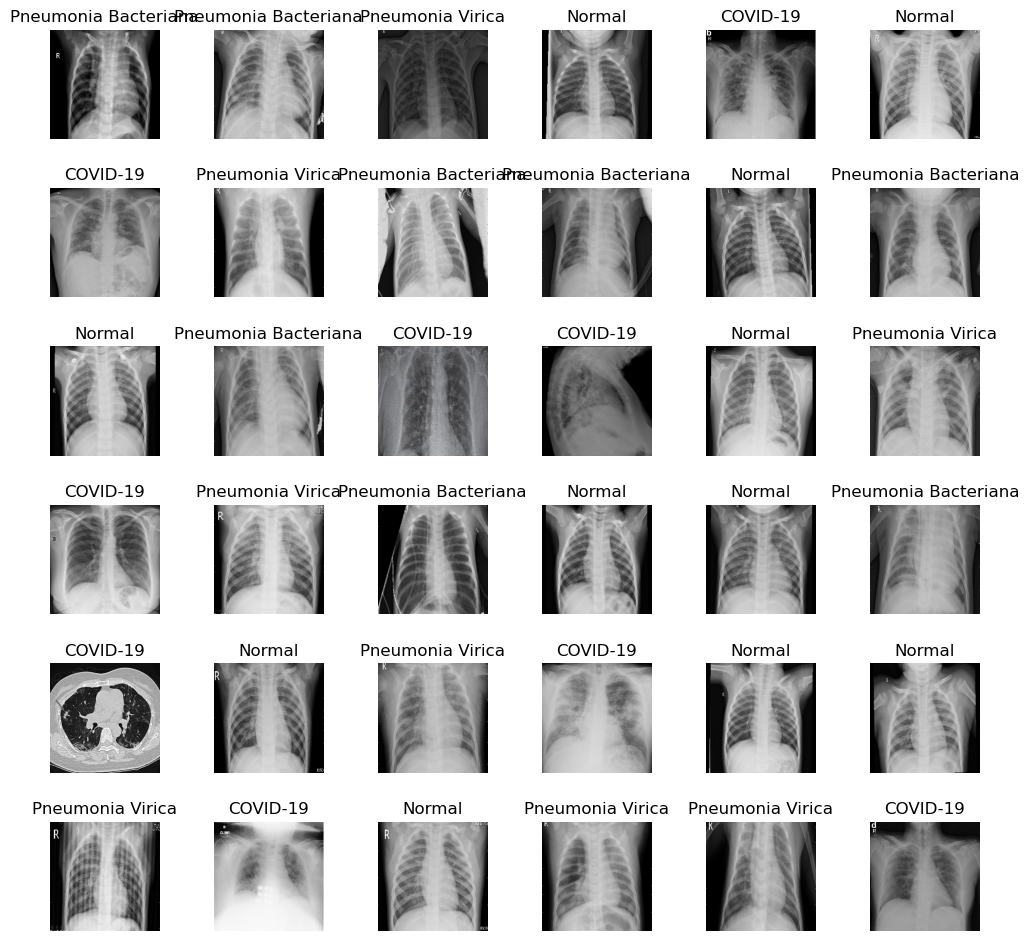

In [10]:
L= 6
W= 6

fig,axes= plt.subplots(L,W, figsize=(12,12))
axes=axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
    
plt.subplots_adjust(wspace=0.5)

In [11]:
basemodel= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

In [12]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 64, 64, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 64, 64, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 64, 64, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 32, 32, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 32, 32, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 32, 32, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 16, 16, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 16, 16, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 16, 16, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 16, 16, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 16, 16, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 16, 16, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 16, 16, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 16, 16, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 8, 8, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 8, 8, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 8, 8, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [13]:
#Congelar el modelo hasta las últimas etapas -4 y llevar a cabo un re entrenamiento -5
for layer in basemodel.layers[:-10]:
    layer.trainable=False

In [14]:
headmodel=basemodel.output
headmodel= AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel= Flatten(name='flatten')(headmodel)
headmodel= Dense(256,activation='relu')(headmodel)
headmodel= Dropout(0.3)(headmodel)
headmodel= Dense(128,activation='relu')(headmodel)
headmodel= Dropout(0.2)(headmodel)
headmodel= Dense(4,activation='softmax')(headmodel)

model= Model(inputs=basemodel.input,outputs=headmodel)

In [15]:
model.compile(loss='categorical_crossentropy',optimizer=legacy.RMSprop(lr=1e-4,decay=1e-6), metrics=['accuracy'])

C:\Users\PC\anaconda3\lib\site-packages\keras\src\optimizers\legacy\rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
earlystopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)

checkpointer=ModelCheckpoint(filepath='weights.hdf5', verbose=1,save_best_only=True)

In [17]:
train_generator= image_generator.flow_from_directory(batch_size=4, directory=df,shuffle=True, target_size=(256,256),class_mode='categorical',subset='training')
val_generator= image_generator.flow_from_directory(batch_size=4, directory=df,shuffle=True, target_size=(256,256),class_mode='categorical',subset='validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [18]:
history= model.fit_generator(train_generator,steps_per_epoch=train_generator.n//4,epochs=25,
                            validation_data=val_generator, validation_steps=val_generator.n//4,
                            callbacks=[checkpointer,earlystopping])

Epoch 1/25


C:\Users\PC\AppData\Local\Temp\ipykernel_9564\505140244.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model.fit_generator(train_generator,steps_per_epoch=train_generator.n//4,epochs=25,


107/107 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.3949
Epoch 1: val_loss improved from inf to 1.39217, saving model to weights.hdf5


C:\Users\PC\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 24s 208ms/step - loss: 1.3836 - accuracy: 0.3949 - val_loss: 1.3922 - val_accuracy: 0.2500
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 1.1365 - accuracy: 0.4650
Epoch 2: val_loss improved from 1.39217 to 1.14374, saving model to weights.hdf5
107/107 [==============================] - 23s 211ms/step - loss: 1.1365 - accuracy: 0.4650 - val_loss: 1.1437 - val_accuracy: 0.4904
Epoch 3/25
107/107 [==============================] - ETA: 0s - loss: 0.9187 - accuracy: 0.6262
Epoch 3: val_loss improved from 1.14374 to 0.94240, saving model to weights.hdf5
107/107 [==============================] - 23s 211ms/step - loss: 0.9187 - accuracy: 0.6262 - val_loss: 0.9424 - val_accuracy: 0.5385
Epoch 4/25
107/107 [==============================] - ETA: 0s - loss: 0.8291 - accuracy: 0.6729
Epoch 4: val_loss improved from 0.94240 to 0.86778, saving model to weights.hdf5
107/107 [==============================] - 23s 212ms/step - loss: 0

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

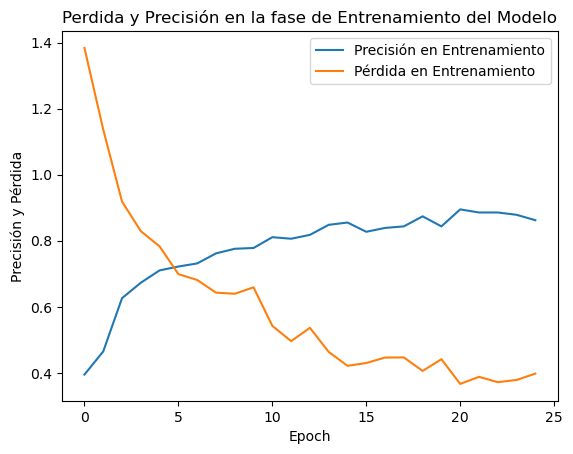

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Perdida y Precisión en la fase de Entrenamiento del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión y Pérdida')
plt.legend(['Precisión en Entrenamiento','Pérdida en Entrenamiento'])

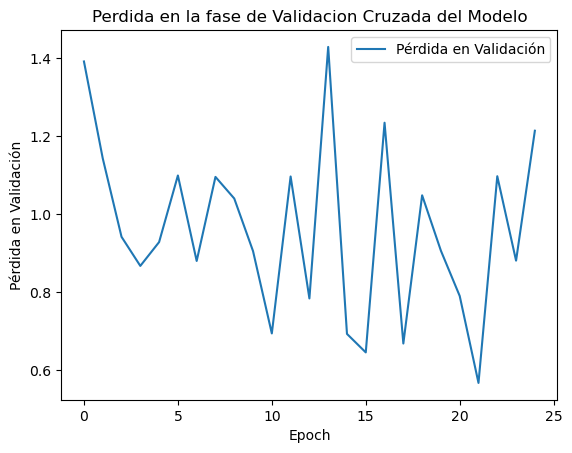

In [21]:
plt.plot(history.history['val_loss'])
plt.title('Perdida en la fase de Validacion Cruzada del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida en Validación')
plt.legend(['Pérdida en Validación'])

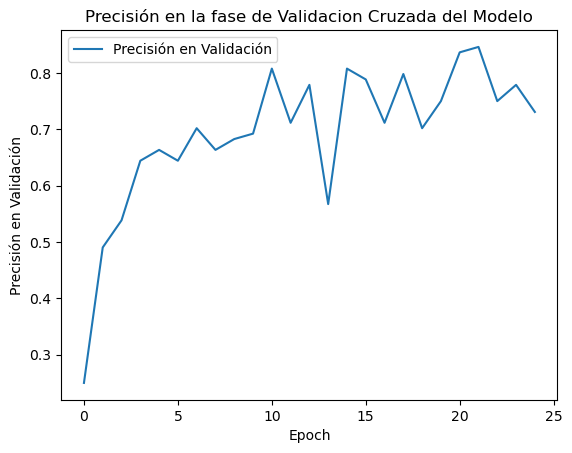

In [22]:
plt.plot(history.history['val_accuracy'])
plt.title('Precisión en la fase de Validacion Cruzada del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión en Validación')
plt.legend(['Precisión en Validación'])

In [23]:
test_directory='C:/Users/PC/Documents/Data+Science+for+Business+Package/DataScienceforBusinessPackage/4. Operations Department/Test'

In [24]:
test_gen= ImageDataGenerator(rescale=1./255)
test_generator= test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle= True,target_size=(256,256), class_mode='categorical')
evaluate= model.evaluate_generator(test_generator,steps=test_generator.n//4,verbose=1)
print('Precisión en la fase Test:{}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.


C:\Users\PC\AppData\Local\Temp\ipykernel_9564\1301894510.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate= model.evaluate_generator(test_generator,steps=test_generator.n//4,verbose=1)


10/10 [==============================] - 2s 83ms/step - loss: 1.6074 - accuracy: 0.5750
Precisión en la fase Test:0.574999988079071


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

prediction=[]
original=[]
image=[]

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory,str(i))):
        img=cv2.imread(os.path.join(test_directory,str(i),item))
        img=cv2.resize(img,(256,256))
        image.append(img)
        img=img/255
        img=img.reshape(-1,256,256,3)
        predict=model.predict(img)
        predict=np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 60ms/step


In [30]:
len(original)

40

In [31]:
score=accuracy_score(original,prediction)
print('Eficacia de la predicción{}'.format(score))

Eficacia de la ´redicción0.6


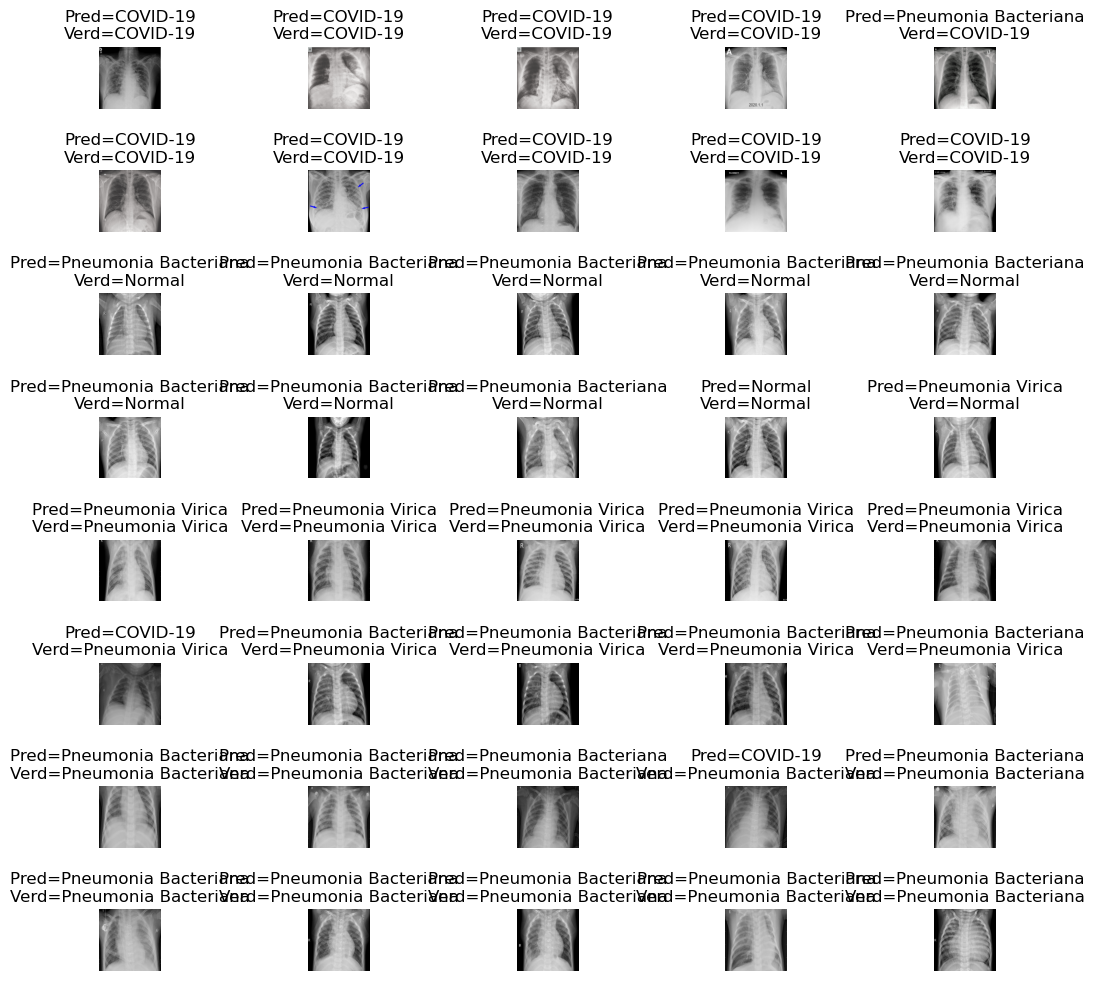

In [34]:
L=8
W=5

fig, axes=plt.subplots(L, W, figsize=(12,12))
axes=axes.ravel()

for i in np.arange(0,L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Pred={}\nVerd={}'.format(str(label_names[prediction[i]]),str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1.2, hspace=1)

In [35]:
print(classification_report(np.asarray(original),np.array(prediction)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       1.00      0.10      0.18        10
           2       0.83      0.50      0.62        10
           3       0.41      0.90      0.56        10

    accuracy                           0.60        40
   macro avg       0.77      0.60      0.56        40
weighted avg       0.77      0.60      0.56        40



Text(0.5, 1.0, 'Matriz de Confusion')

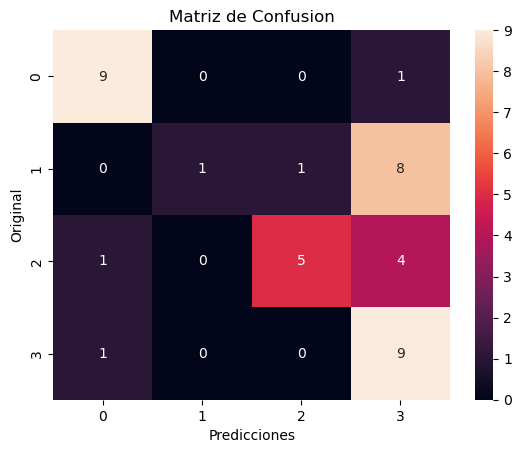

In [36]:
cm=confusion_matrix(np.asarray(original),np.array(prediction))
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax=ax)
ax.set_xlabel('Predicciones')
ax.set_ylabel('Original')
ax.set_title('Matriz de Confusion')